In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pybullet as p
import pybullet_data
import time
import random
import cv2
from decimal import Decimal
import os
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
# Bicycle and its environment

#del env
cv2.destroyAllWindows()

class CycleBalancingEnv(gym.Env):
    metadata = {'render.modes': ['human']}  
  
    def __init__(self):
        # Out cycle has only 2 action spaces i.e. Torque of the wheels and the position of the handlebar
        self.action_space = gym.spaces.box.Box(
            low=-1 * np.ones(1, dtype=np.float32),
            high=1 * np.ones(1, dtype=np.float32))
        # Obervation space
        self.observation_space = gym.spaces.box.Box(
            low=-1 * np.ones(24, dtype=np.float32),
            high=1 * np.ones(24, dtype=np.float32))
        self.np_random, _ = gym.utils.seeding.np_random()

        if not p.isConnected():
            self.client = p.connect(p.GUI)
        else:
            self.client = 1
        #self.client = p.connect(p.SHARED_MEMORY)        
        #self.client = p.connect(p.DIRECT)
        
        self.n_target = 200
        self.min_target_dist = 5
        self.target_span = 100
        self.sphere_dist = 1.5
        self.pole = []
        p.resetSimulation(self.client)
        p.setRealTimeSimulation(0)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.plane=p.loadURDF("plane.urdf",[0,0,0], useFixedBase=True)
        self.bike = 0
        self.angle_span = 20
        self.n_episodes = 0
        self.rays_distance = 30
        self.z_balance = -0.25
        self.z_target = -1
        
        self.make_obstacles()
        self.reset()
        #self.show_img()
        
    def show_img(self):
        
        self.img = np.zeros((800,800,3), dtype='float32')
        shift = 400
        multiply = 400
        ls = p.getBasePositionAndOrientation(self.bike)
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        mini = 1000
        #print(self.dist)
        for deg in range(1, 361, 1):
            mini = min(mini, self.dist[deg-1])
            if deg%self.angle_span==0:
                rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
                rad = float(rad)
                #p.removeBody(self.sphere[cnt])
                #self.sphere[cnt] = p.loadURDF('sphere_small.urdf', [bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), 1], [0,0,0,1])
                #cnt += 1
                start = (int(shift + bike_x + self.sphere_dist*np.cos(rad)), int(shift + bike_y + self.sphere_dist*np.sin(rad)))
                end = (int(shift + bike_x + mini*multiply*np.cos(rad)), int(shift + bike_y + mini*multiply*np.sin(rad)))
                #cv2.line(self.img, start, end, (0,0,255), 10)
                cv2.ellipse(self.img, start, (int(mini*multiply),int(mini*multiply)), 0, (rad*180/np.pi)-self.angle_span, (rad*180/np.pi), (0,0,255), -1)
                mini = 1000
            
        #cv2.destroyAllWindows()
        cv2.imshow('img', cv2.rotate(cv2.transpose(self.img), cv2.ROTATE_180))
        #cv2.imshow('img', self.img)
        cv2.waitKey(1)
        #cv2.destroyAllWindows()

    def step(self, action):
        
        p.setJointMotorControl2(self.bike, 0, p.POSITION_CONTROL, targetPosition=action[0], maxVelocity=5) # Apply Position control to Handlebar
        for i in range(3):
            p.setJointMotorControl2(self.bike,1,p.TORQUE_CONTROL , force=(2.5+0)*10000) # Apply Toruqe to Back Wheel
            p.setJointMotorControl2(self.bike,2,p.TORQUE_CONTROL , force=(2.5+0)*10000) # Apply Toruqe to Front Wheel
            ls = p.getBasePositionAndOrientation(self.bike) # ls[0]=Postion of cycle, ls[1] = Orientation of cycle
            val = p.getEulerFromQuaternion(ls[1])[0] - 1.57 # Calculating inclination of cycle from vertical
            p.applyExternalTorque(self.bike, -1, [-1000000*val, 0, 0], flags=p.WORLD_FRAME)
            p.stepSimulation()
        
        #p.applyExternalTorque(self.bike, -1, [-1000000*val, 0, 0], flags=p.WORLD_FRAME)
        
        #p.applyExternalTorque(self.bike, -1, [-20000*action[2], 0, 0], flags=p.LINK_FRAME)
        #p.setJointMotorControl2(self.bike, 3, p.POSITION_CONTROL, targetPosition=action[2], maxVelocity=100)
        #ls_tmp = p.getLinkState(self.bike, 3)
        #p.applyExternalForce(self.bike, 3, [0,0,10000], ls_tmp[2], p.LINK_FRAME)
        
        ls = p.getBasePositionAndOrientation(self.bike) # ls[0]=Postion of cycle, ls[1] = Orientation of cycle
        val = p.getEulerFromQuaternion(ls[1])[0] - 1.57 # Calculating inclination of cycle from vertical
#         reward_0 = (abs(val)) * -1 # Calculae reward based on the angle of inclination
        
#         p.applyExternalTorque(self.bike, -1, [-1000000*val, 0, 0], flags=p.WORLD_FRAME)
        
        
            #p.stepSimulation()
            
        z = ls[0][2] + self.z_balance
        
#         reward_0 = 0
#         if abs(val)>0.5:
#             reward_0 = (abs(val)) * -10
#         if abs(val)>1.2: # Terminate the episode if the angle of inclination from vertical is greater than 1.2 radian i.e 70 degree 
#             self.done=True
#             reward_0 = -200
            
        tmp = ls[0]
        self.bike_x = tmp[0]
        self.bike_y = tmp[1]
        
        # Calculating the position, orientation, velocity of all the joints of the cycle
        obs = []
#         for i in range(p.getNumJoints(self.bike)):
#             ls = p.getLinkState(self.bike, i, computeLinkVelocity=1, computeForwardKinematics=1)
#             for x in ls:
#                 for val in x:
#                     obs.append(val)
        ls = p.getBasePositionAndOrientation(self.bike)
        obs += ls[0] + p.getEulerFromQuaternion(ls[1])
        
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        reward_2 = 0
        #cnt = 0
        ray_from = []
        ray_to = []
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        for deg in range(1, 361, 1):
            rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
            rad = float(rad)
            #p.removeBody(self.sphere[cnt])
            #self.sphere[cnt] = p.loadURDF('sphere_small.urdf', [bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), 1], [0,0,0,1])
            #cnt += 1
            for i in np.arange(0, 3, 1):
                for j in np.arange(-4, 1, 0.5):
                    ray_from.append((bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), z+i))
                    ray_to.append((bike_x + self.rays_distance*np.cos(rad), bike_y + self.rays_distance*np.sin(rad), z+j))
        
        #print(len(ray_from), len(ray_to))
        rays = p.rayTestBatch(ray_from, ray_to)
        mini = 1000
        self.dist = []
        mini = 1000
        #assert(len(rays)==360)
        cnt = 0
        for deg in range(1, 361, 1):
            dist = 1
            for i in np.arange(0, 3, 1):
                for j in np.arange(-4, 1, 0.5):
                    tmp = rays[cnt]
                    cnt += 1
                    if tmp[0]!=self.plane: dist = min(dist, tmp[2])
            if dist<mini:
                mini = dist
            self.dist.append(dist)
            if deg%self.angle_span==0:
                obs.append(mini)
                mini = 1000
    
        tmp = p.getContactPoints(self.bike)
        for i in range(len(tmp)):
            if tmp[i][2]!=0:
                reward_2 = -100
                self.done = True
        
        self.time += 1 # Adding 1 to the time for which the current episode has been running
        
        # Terminating the episode if the cycle covers less than 1 units distance in 200 timesteps
        dist_2 = np.sqrt((self.bike_x)**2 + abs(self.bike_y)**2)
        if self.time%10==0 and dist_2>self.distance: self.distance = dist_2
        
        value = p.getEulerFromQuaternion(p.getLinkState(self.bike, 0)[1])[2] - p.getEulerFromQuaternion(ls[1])[2]
        if value<-1: value += 2*np.pi
        if value>1: value -= 2*np.pi
        #print(value)
        if value < -0.5:
            self.left += 0.1
            self.right = 0
        elif value > 0.5:
            self.left = 0
            self.right += 0.1
        else:
            self.left = 0
            self.right = 0
            
        self.neg_reward = 0
        if self.left>10 or self.right>10:
            print("Slow!!!")
            self.neg_reward = -100
            self.done = True
            
        if self.done:
            print(self.left, self.right, dist_2)
            
            
        # Terminating the episode if the cycle is more than 80units distance from the origin
        val = self.target_span
        reward_1 = 0
        if dist_2 > self.target_dist:
            reward_1 = 100 + self.target_reward
            self.target_dist += 10
            self.target_reward = min(500, self.target_reward*2)
            
        self.completed = 0
        if dist_2 > val:
            self.completed = 1
            self.done = True
            print("DONE!")
            self.make_obstacles()
        
        # Calculating the total reward
        reward = reward_1 + reward_2 + max(-10, (dist_2-self.distance)) + self.time/1000 + self.neg_reward - self.left - self.right
        #print(mini, end=" ")
        
#         obs.append(self.time)
#         obs.append(self.cnt)
#         obs.append(self.left)
#         obs.append(self.right)
#         obs.append(action[0])
#         obs.append(dist_2)
#         obs.append(self.distance)

        obs = np.array(obs, dtype=np.float32)
        obs[0] /= self.target_span
        obs[1] /= self.target_span
        #print(obs.shape)
        
#         if self.time%50==10:
#             for deg in range(-90, 90, 5):
#                 rad = deg * np.pi/180 + p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2] + 2*np.pi
#                 self.sphere.append(p.loadURDF('sphere_small.urdf', [bike_x + (self.sphere_dist+1*rad)*np.cos(rad), bike_y + (self.sphere_dist+1*rad)*np.sin(rad), 1], [0,0,0,1], useFixedBase=True, globalScaling=(deg+90)/10))
#             #time.sleep(5.0)
#         if self.time%50==40 or self.done:
#             for i in self.sphere:
#                 p.removeBody(i)
#             #time.sleep(5.0)

#         if self.time%10==0 and not self.done:
#             self.show_img()

#         if self.time%50==0:
#             self.make_sphere()

        return obs, reward/100, self.done, dict()


    def reset(self):
        
        self.n_episodes += 1
        if self.n_episodes==20:
            self.make_obstacles()
            self.n_episodes = 0
        
        #p.resetSimulation(self.client)
        #p.setRealTimeSimulation(0)
        #p.setAdditionalSearchPath(pybullet_data.getDataPath())
        
        # Loading the plane
        #self.plane=p.loadURDF("plane.urdf",[0,0,0], useFixedBase=True)
        
        if self.bike!=0:
            p.removeBody(self.bike)
        # Loading the cycle
        self.bike_x = 0 # random.randint(-5, 5) # X position of the cycle
        self.bike_y = 0 # random.randint(-5, 5) # Y position of the cycle
        self.bike=p.loadURDF("bike_2.urdf.xml",[self.bike_x, self.bike_y,0], p.getQuaternionFromEuler([0,0, random.random()*2*np.pi]),  useFixedBase=False)
        
        for i in range(10):
            p.stepSimulation()
            
        # Loading the target
#         self.pole = []
#         for i in range(self.n_target):
#             target_x = self.bike_x
#             target_y = self.bike_y
#             while (np.sqrt( (self.bike_x - target_x)**2 + (self.bike_y - target_y)**2 )) < self.min_target_dist:
#                 target_x = random.randint(int(self.bike_x) - self.target_span, int(self.bike_x) + self.target_span)
#                 target_y = random.randint(int(self.bike_y) - self.target_span, int(self.bike_y) + self.target_span)
#             self.pole.append( p.loadURDF("cube.urdf",[target_x, target_y, 1], [0,0,0,1], useFixedBase=True, globalScaling=3.0) )
        
        # Adding friction and other dynamics
        p.changeDynamics(self.plane, -1, lateralFriction=5, angularDamping=1)
        p.changeDynamics(self.bike, 1, mass=100)
        #p.changeDynamics(self.bike, 2, mass=100, lateralFriction=1, angularDamping=3, rollingFriction=0.01)
        p.changeDynamics(self.bike, -1, lateralFriction=5, angularDamping=1)
        
        p.setGravity(0, 0, -250) # Setting the gravity
        #p.setRealTimeSimulation(0)
        self.done=False
        self.time = 0
        self.distance = np.sqrt((self.bike_x)**2 + abs(self.bike_y)**2)
        self.neg_reward = 0
        
        # Calculating the initial observation space
        obs = []
#         for i in range(p.getNumJoints(self.bike)):
#             ls = p.getLinkState(self.bike, i, computeLinkVelocity=1, computeForwardKinematics=1)
#             for x in ls:
#                 for val in x:
#                     obs.append(val)
        ls = p.getBasePositionAndOrientation(self.bike)
        obs += ls[0] + p.getEulerFromQuaternion(ls[1])
        z = ls[0][2] + self.z_balance
        
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        self.sphere = []
        mini = 1000
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        for deg in range(1, 361, 1):
            rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
            rad = float(rad)
            #p.loadURDF('sphere_small.urdf', [bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), 1], [0,0,0,1])
            #p.loadURDF('sphere_small.urdf', [bike_x + (self.sphere_dist+1*rad)*np.cos(rad), bike_y + (self.sphere_dist+1*rad)*np.sin(rad), 1], [0,0,0,1], useFixedBase=True, globalScaling=deg/10)
            #p.loadURDF('sphere_small.urdf', [bike_x + 10*np.cos(rad), bike_y + 10*np.sin(rad), 1], [0,0,0,1])
            dist = 1
            for i in np.arange(0, 3, 1):
                for j in np.arange(-4, 1, 0.5):
                    tmp = p.rayTest((bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), z+i), (bike_x + self.rays_distance*np.cos(rad), bike_y + self.rays_distance*np.sin(rad), z+j))[0]
                    if tmp[0]!=self.plane: dist = min(dist, tmp[2])
            mini = min(mini, dist)
            if deg%self.angle_span==0:
                obs.append(mini)
                mini = 1000
        
        self.cnt = 0
        self.left = 0
        self.right = 0
        self.target_dist = 10
        self.target_reward = 32
        self.completed = 0
#         obs.append(self.time)
#         obs.append(self.cnt)
#         obs.append(self.left)
#         obs.append(self.right)
#         obs.append(0)
#         obs.append(0)
#         obs.append(self.distance)
        
        obs = np.array(obs, dtype=np.float32)
        obs[0] /= self.target_span
        obs[1] /= self.target_span
        return obs

    def make_obstacles(self):
        
        p.resetSimulation(self.client)
        p.setRealTimeSimulation(0)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        #self.plane=p.loadURDF("plane.urdf",[0,0,0], useFixedBase=True)
        mul = 100
        height = 2
        visualShift = [0, 0, 0]
        shift = [0, 0, 0]
        meshScale=[0.1*mul, 0.1*mul, 0.1*mul*height]
        path = 'C:/Users/User/Documents/GitHub/bullet3/examples/pybullet/gym/pybullet_data/'
        groundColId = p.createCollisionShape(shapeType=p.GEOM_MESH, 
                                                  fileName=os.path.join(path, "terrain.obj"), 
                                                  collisionFramePosition=shift,
                                                  meshScale=meshScale,
                                                  flags=p.GEOM_FORCE_CONCAVE_TRIMESH)
        groundVisID = p.createVisualShape(shapeType=p.GEOM_MESH, 
                                            fileName=os.path.join(path, "terrain.obj"), 
                                            rgbaColor=[0.7,0.3,0.1,1],
                                            specularColor=[0.4,.4,0],
                                            visualFramePosition=visualShift,
                                            meshScale=meshScale)
        self.plane = p.createMultiBody(baseMass=0,
                                              baseInertialFramePosition=[0,0,0],
                                              baseCollisionShapeIndex=groundColId, 
                                              baseVisualShapeIndex=groundVisID, 
                                              basePosition=[0,0,0], 
                                              useMaximalCoordinates=True)
        self.bike = 0
        
#         for i in self.pole:
#             p.removeBody(i)
            
        self.bike_x = 0
        self.bike_y = 0
        self.pole = []
        for i in range(self.n_target):
            target_x = self.bike_x
            target_y = self.bike_y
            while (np.sqrt( (self.bike_x - target_x)**2 + (self.bike_y - target_y)**2 )) < self.min_target_dist:
                target_x = random.randint(int(self.bike_x) - self.target_span, int(self.bike_x) + self.target_span)
                target_y = random.randint(int(self.bike_y) - self.target_span, int(self.bike_y) + self.target_span)
            self.pole.append( p.loadURDF("C:/Users/User/Documents/GitHub/bullet3/examples/pybullet/gym/pybullet_data/cube.urdf",[target_x, target_y, 4], [0,0,0,1], useFixedBase=True, globalScaling=1.0) )
            p.changeDynamics(self.pole[i], -1, mass=1000)
            
    def make_sphere(self):
        for i in self.sphere:
            p.removeBody(i)
            
        ls = p.getBasePositionAndOrientation(self.bike)
        z = ls[0][2] + self.z_balance
        bike_x = ls[0][0]
        bike_y = ls[0][1]
        self.sphere = []
        handlebar_rotation = p.getEulerFromQuaternion( p.getLinkState(self.bike, 0)[1] )[2]
        for deg in range(1, 361, 10):
            rad = Decimal( Decimal(deg * np.pi/180 + handlebar_rotation)%Decimal(2*np.pi) + Decimal(2*np.pi))%Decimal(2*np.pi)
            rad = float(rad)
            #self.sphere.append(p.loadURDF('sphere_small.urdf', [bike_x + self.sphere_dist*np.cos(rad), bike_y + self.sphere_dist*np.sin(rad), z], [0,0,0,1]))
            #p.loadURDF('sphere_small.urdf', [bike_x + (self.sphere_dist+1*rad)*np.cos(rad), bike_y + (self.sphere_dist+1*rad)*np.sin(rad), 1], [0,0,0,1], useFixedBase=True, globalScaling=deg/10)
            self.sphere.append(p.loadURDF('sphere_small.urdf', [bike_x + self.rays_distance*np.cos(rad), bike_y + self.rays_distance*np.sin(rad), z+(abs(deg-180)*(-self.rays_distance/90.)+self.rays_distance)*np.tan(p.getEulerFromQuaternion(ls[1])[1])], [0,0,0,1], useFixedBase=True))
        print(ls[1], p.getEulerFromQuaternion(ls[1]))
        
    def render(self, mode='human'):
            
        #p.stepSimulation()
        
        distance=5
        yaw = 0
        humanPos, humanOrn = p.getBasePositionAndOrientation(self.bike)
        humanBaseVel = p.getBaseVelocity(self.bike)
        #print("frame",frame, "humanPos=",humanPos, "humanVel=",humanBaseVel)
        camInfo = p.getDebugVisualizerCamera()
        curTargetPos = camInfo[11]
        distance=camInfo[10]
        yaw = camInfo[8]
        pitch=camInfo[9]
        targetPos = [0.95*curTargetPos[0]+0.05*humanPos[0],0.95*curTargetPos[1]+0.05*humanPos[1],curTargetPos[2]]
        
        p.resetDebugVisualizerCamera(distance,270 ,pitch,targetPos)

    def close(self):
        p.disconnect(self.client)

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

In [3]:
env = CycleBalancingEnv()
env.reset().shape

(24,)

In [4]:
print(env.observation_space.sample().shape)
print(env.action_space.sample())

(24,)
[-0.81429106]


In [ ]:
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        action = [0.]
        n_state, reward, done, info = env.step(action)
        score+=reward
        time.sleep(1/240.)
    print('Episode:{} Score:{}'.format(episode, score))
#env.close()

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [6]:
states = env.observation_space.shape # Shape of our observation space
nb_actions = env.action_space.shape[0] # shape of our action space
states, nb_actions

((24,), 1)

In [ ]:
del actor, critic

In [7]:
# Defining our actor model for the DDPG algorithm

actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
# actor.add(LSTM(32, input_shape=(8,) + env.observation_space.shape))
# actor.add(Flatten())
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
actor.add(Dense(32, kernel_initializer='he_uniform'))
actor.add(Activation('relu'))
# actor.add(Reshape((1, -1)))
# actor.add(LSTM(32))
actor.add(Dense(nb_actions))
actor.add(Activation('tanh'))
print(actor.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                800       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0

In [8]:
# Defining our critic network for the DDPG algorithm

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = tf.keras.Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(32, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = tf.keras.Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 24)]      0                                            
__________________________________________________________________________________________________
action_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 24)           0           observation_input[0][0]          
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 25)           0           action_input[0][0]               
                                                                 flatten_1[0][0]              

In [9]:
#from rl.agents import DQNAgent, SARSAAgent, DDPGAgent
#from rl.agents.sarsa import SARSAAgent
from rl.policy import BoltzmannQPolicy, BoltzmannGumbelQPolicy, SoftmaxPolicy,  EpsGreedyQPolicy, GreedyQPolicy, BoltzmannGumbelQPolicy
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.util import *

In [10]:
episode_reward = []

In [ ]:
# Defining our DDPG agent

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta= 0.01, mu=0, sigma=.03)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=20, nb_steps_warmup_actor=20,
                  random_process=random_process, gamma=0.95, target_model_update=1e-3)

In [ ]:
agent.compile([Adam(lr=.00001, clipnorm=1.0), Adam(lr=.001, clipnorm=1.0)], metrics=['mae'])

In [11]:
import numpy as np
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

from rl.core import Agent
from rl.policy import Policy
from rl.util import *


def mean_q(y_true, y_pred):
    return K.mean(K.max(y_pred, axis=-1))

In [12]:
import numpy as np
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

from rl.core import Agent
from rl.policy import Policy
from rl.util import *


def mean_q(y_true, y_pred):
    return K.mean(K.max(y_pred, axis=-1))

class DDPGAgent(Agent):
    """
    # Arguments
        nb_actions: Number of actions
        actor, critic: Keras models
        critic_action_input: input layer in critic model that corresponds to actor output
        enable_twin_delay: enable Twin Delayed DDPG
        random_process: noise to add to actor during training when agent performs forward pass
        policy_delay: how many steps to delay policy updates by wrt critic updates
        noise_sigma: noise to add to actor during training when agent performs backward pass, for critic policy update (TD3)
        noise_clip: value to clip above noise by (TD3)
    """
    def __init__(self, nb_actions, actor, critic, critic_action_input, memory,
                 gamma=.99, batch_size=32, nb_steps_warmup_critic=1000, nb_steps_warmup_actor=1000,
                 train_interval=1, memory_interval=1, delta_range=None, delta_clip=np.inf,
                 random_process=None, custom_model_objects={}, target_model_update=.001,
                 policy=None, enable_twin_delay=False, policy_delay=None, noise_clip=0.5,
                 noise_sigma=0.2, **kwargs):

        super(DDPGAgent, self).__init__(**kwargs)

        # Soft vs hard target model updates.
        if target_model_update < 0:
            raise ValueError('`target_model_update` must be >= 0.')
        elif target_model_update >= 1:
            # Hard update every `target_model_update` steps.
            target_model_update = int(target_model_update)
        else:
            # Soft update with `(1 - target_model_update) * old + target_model_update * new`.
            target_model_update = float(target_model_update)

        if delta_range is not None:
            warnings.warn('`delta_range` is deprecated. Please use `delta_clip` instead, which takes a single scalar. For now we\'re falling back to `delta_range[1] = {}`'.format(delta_range[1]))
            delta_clip = delta_range[1]

        # Parameters.
        self.enable_twin_delay = enable_twin_delay
        self.nb_actions = nb_actions
        self.nb_steps_warmup_actor = nb_steps_warmup_actor
        self.nb_steps_warmup_critic = nb_steps_warmup_critic
        self.random_process = random_process
        self.gamma = gamma
        self.target_model_update = target_model_update
        self.batch_size = batch_size
        self.train_interval = train_interval
        self.memory_interval = memory_interval
        self.custom_model_objects = custom_model_objects
        self.policy_delay = policy_delay
        if policy_delay is None:
            if self.enable_twin_delay:
                self.policy_delay = 2
            else:
                self.policy_delay = 1
        if policy is None:
            self.policy = DDPGPolicy()
        self.noise_clip = noise_clip
        self.noise_sigma = noise_sigma
        self.delta_clip = delta_clip

        # Related objects.
        self.actor = actor
        self.critic = critic
        self.critic_action_input = critic_action_input
        self.critic_action_input_idx = self.critic.input.index(critic_action_input)
        self.memory = memory

        # State.
        self.compiled = False
        self.reset_states()

    @property
    def uses_learning_phase(self):
        return self.actor.uses_learning_phase or self.critic.uses_learning_phase

    def compile(self, optimizer, metrics=[]):
        metrics += [mean_q]

        if type(optimizer) in (list, tuple):
            if len(optimizer) != 2:
                raise ValueError('More than two optimizers provided. Please only provide a maximum of two optimizers, the first one for the actor and the second one for the critic.')
            actor_optimizer, critic_optimizer = optimizer
        else:
            actor_optimizer = optimizer
            critic_optimizer = clone_optimizer(optimizer)
        if type(actor_optimizer) is str:
            actor_optimizer = optimizers.get(actor_optimizer)
        if type(critic_optimizer) is str:
            critic_optimizer = optimizers.get(critic_optimizer)
        assert actor_optimizer != critic_optimizer

        if len(metrics) == 2 and hasattr(metrics[0], '__len__') and hasattr(metrics[1], '__len__'):
            actor_metrics, critic_metrics = metrics
        else:
            actor_metrics = critic_metrics = metrics

        def clipped_error(y_true, y_pred):
            return K.mean(huber_loss(y_true, y_pred, self.delta_clip), axis=-1)

        # Compile target networks. We only use them in feed-forward mode, hence we can pass any
        # optimizer and loss since we never use it anyway.
        self.target_actor = clone_model(self.actor, self.custom_model_objects)
        self.target_actor.compile(optimizer='sgd', loss='mse')
        self.target_critic = clone_model(self.critic, self.custom_model_objects)
        self.target_critic.compile(optimizer='sgd', loss='mse')

        # We also compile the actor. We never optimize the actor using Keras but instead compute
        # the policy gradient ourselves. However, we need the actor in feed-forward mode, hence
        # we also compile it with any optimzer and
        self.actor.compile(optimizer='sgd', loss='mse')

        # Compile the critic.
        if self.target_model_update < 1.:
            # We use the `AdditionalUpdatesOptimizer` to efficiently soft-update the target model.
            critic_updates = get_soft_target_model_updates(self.target_critic, self.critic, self.target_model_update)
            critic_optimizer = AdditionalUpdatesOptimizer(critic_optimizer, critic_updates)
        self.critic.compile(optimizer=critic_optimizer, loss=clipped_error, metrics=critic_metrics)

        # Set up second critic network for TD3
        if self.enable_twin_delay:
            self.critic2 = clone_model(self.critic, self.custom_model_objects)
            self.critic2.compile(optimizer=critic_optimizer, loss=clipped_error, metrics=critic_metrics)
            self.target_critic2 = clone_model(self.critic2, self.custom_model_objects)
            self.target_critic2.compile(optimizer='sgd', loss='mse')

        # Combine actor and critic so that we can get the policy gradient.
        # Assuming critic's state inputs are the same as actor's.
        combined_inputs = []
        state_inputs = []
        for i in self.critic.inputs:
            if i == self.critic_action_input:
                combined_inputs.append([])
            else:
                combined_inputs.append(i)
                state_inputs.append(i)
        combined_inputs[self.critic_action_input_idx] = self.actor(state_inputs)

        combined_output = self.critic(combined_inputs)
        updates = actor_optimizer.get_updates(
            params=self.actor.trainable_weights, loss=-K.mean(combined_output))
        if self.target_model_update < 1.:
            # Include soft target model updates.
            updates += get_soft_target_model_updates(self.target_actor, self.actor, self.target_model_update)
        updates += self.actor.updates  # include other updates of the actor, e.g. for BN

        # Finally, combine it all into a callable function.
        if K.backend() == 'tensorflow':
            self.actor_train_fn = K.function(state_inputs + [K.learning_phase()],
                                             [self.actor(state_inputs)], updates=updates)
        else:
            if True: #self.uses_learning_phase:
                state_inputs += [K.learning_phase()]
            self.actor_train_fn = K.function(state_inputs, [self.actor(state_inputs)], updates=updates)
        self.actor_optimizer = actor_optimizer

        self.compiled = True

    def load_weights(self, filepath):
        filename, extension = os.path.splitext(filepath)
        actor_filepath = filename + '_actor' + extension
        critic_filepath = filename + '_critic' + extension
        self.actor.load_weights(actor_filepath)
        self.critic.load_weights(critic_filepath)
        self.update_target_models_hard()

    def save_weights(self, filepath, overwrite=False):
        filename, extension = os.path.splitext(filepath)
        actor_filepath = filename + '_actor' + extension
        critic_filepath = filename + '_critic' + extension
        self.actor.save_weights(actor_filepath, overwrite=overwrite)
        self.critic.save_weights(critic_filepath, overwrite=overwrite)

    def update_target_models_hard(self):
        self.target_critic.set_weights(self.critic.get_weights())
        self.target_actor.set_weights(self.actor.get_weights())
        if self.enable_twin_delay:
            self.target_critic2.set_weights(self.critic2.get_weights())

    # TODO: implement pickle

    def reset_states(self):
        if self.random_process is not None:
            self.random_process.reset_states()
        self.recent_action = None
        self.recent_observation = None
        if self.compiled:
            self.actor.reset_states()
            self.critic.reset_states()
            self.target_actor.reset_states()
            self.target_critic.reset_states()
            if self.enable_twin_delay:
                self.critic2.reset_states()
                self.target_critic2.reset_states()

    def process_state_batch(self, batch):
        batch = np.array(batch)
        if self.processor is None:
            return batch
        return self.processor.process_state_batch(batch)

    def forward(self, observation):
        # Select an action.
        state = self.memory.get_recent_state(observation)
        batch = self.process_state_batch([state])
        action = self.actor.predict_on_batch(batch).flatten()
        assert action.shape == (self.nb_actions,)

        if self.training:
            action = self.policy.select_action(action, self.random_process,
                                               noise_clip=None)

        # Book-keeping.
        self.recent_observation = observation
        self.recent_action = action

        return action

    @property
    def layers(self):
        return self.actor.layers[:] + self.critic.layers[:]

    @property
    def metrics_names(self):
        names = self.critic.metrics_names[:]
        if self.enable_twin_delay:
            names += self.critic2.metrics_names[:]
        if self.processor is not None:
            names += self.processor.metrics_names[:]
        return names

    def backward(self, reward, terminal=False):
        # Store most recent experience in memory.
        if self.step % self.memory_interval == 0:
            self.memory.append(self.recent_observation, self.recent_action, reward, terminal,
                               training=self.training)

        metrics = [np.nan for _ in self.metrics_names]
        if not self.training:
            # We're done here. No need to update the experience memory since we only use the working
            # memory to obtain the state over the most recent observations.
            return metrics

        # Train the network on a single stochastic batch.
        can_train_either = self.step > self.nb_steps_warmup_critic or self.step > self.nb_steps_warmup_actor
        if can_train_either and self.step % self.train_interval == 0:
            experiences = self.memory.sample(self.batch_size)
            assert len(experiences) == self.batch_size

            # Start by extracting the necessary parameters (we use a vectorized implementation).
            state0_batch = []
            reward_batch = []
            action_batch = []
            terminal1_batch = []
            state1_batch = []
            for e in experiences:
                state0_batch.append(e.state0)
                state1_batch.append(e.state1)
                reward_batch.append(e.reward)
                action_batch.append(e.action)
                terminal1_batch.append(0. if e.terminal1 else 1.)

            # Prepare and validate parameters.
            state0_batch = self.process_state_batch(state0_batch)
            state1_batch = self.process_state_batch(state1_batch)
            terminal1_batch = np.array(terminal1_batch)
            reward_batch = np.array(reward_batch)
            action_batch = np.array(action_batch)
            assert reward_batch.shape == (self.batch_size,)
            assert terminal1_batch.shape == reward_batch.shape
            assert action_batch.shape == (self.batch_size, self.nb_actions)

            # Update critic, if warm up is over.
            if self.step > self.nb_steps_warmup_critic:
                target_actions = self.target_actor.predict_on_batch(state1_batch)
                if self.enable_twin_delay:
                    # Add clipped noise to target actions
                    target_actions = self.policy.select_action(target_actions, noise_sigma=self.noise_sigma, noise_clip=self.noise_clip)
                assert target_actions.shape == (self.batch_size, self.nb_actions)
                if len(self.critic.inputs) >= 3:
                    state1_batch_with_action = state1_batch[:]
                else:
                    state1_batch_with_action = [state1_batch]
                state1_batch_with_action.insert(self.critic_action_input_idx, target_actions)
                if self.enable_twin_delay:
                    target_q1_values = self.target_critic.predict_on_batch(state1_batch_with_action).flatten()
                    target_q2_values = self.target_critic2.predict_on_batch(state1_batch_with_action).flatten()
                    target_q_values = np.minimum(target_q1_values, target_q2_values)
                else:
                    target_q_values = self.target_critic.predict_on_batch(state1_batch_with_action).flatten()
                assert target_q_values.shape == (self.batch_size,)

                # Compute r_t + gamma * max_a Q(s_t+1, a) and update the target ys accordingly,
                # but only for the affected output units (as given by action_batch).
                discounted_reward_batch = self.gamma * target_q_values
                discounted_reward_batch *= terminal1_batch
                assert discounted_reward_batch.shape == reward_batch.shape
                targets = (reward_batch + discounted_reward_batch).reshape(self.batch_size, 1)

                # Perform a single batch update on the critic network.
                if len(self.critic.inputs) >= 3:
                    state0_batch_with_action = state0_batch[:]
                else:
                    state0_batch_with_action = [state0_batch]
                state0_batch_with_action.insert(self.critic_action_input_idx, action_batch)
                metrics = self.critic.train_on_batch(state0_batch_with_action, targets)
                if not isinstance(metrics, list):
                    metrics = [metrics]
                if self.enable_twin_delay:
                    metrics2 = self.critic2.train_on_batch(state0_batch_with_action, targets)
                    if not isinstance(metrics, list):
                        metrics2 = [metrics2]
                    metrics += metrics2
                if self.processor is not None:
                    metrics += self.processor.metrics

            # Update actor, if warm up is over.
            if self.step > self.nb_steps_warmup_actor and self.step % self.policy_delay == 0:
                # TODO: implement metrics for actor
                if len(self.actor.inputs) >= 2:
                    inputs = state0_batch[:]
                else:
                    inputs = [state0_batch]
                if True: #self.uses_learning_phase:
                    inputs += [self.training]
                action_values = self.actor_train_fn(inputs)[0]
                assert action_values.shape == (self.batch_size, self.nb_actions)

        if self.target_model_update >= 1 and self.step % self.target_model_update == 0:
            self.update_target_models_hard()

        return metrics

class DDPGPolicy(Policy):
    """
    Adds noise sampled from random_process to action.
    If random_process is None, draws from N(0, noise_sigma) distribution.
    If noise_clip is not None, clips noise to [-noise_clip, noise_clip]
    """
    def select_action(self, action, random_process=None,
                      noise_sigma=0.2, noise_clip=None):
        if random_process is not None:
            noise = random_process.sample()
        else:
            noise = np.random.normal(0, noise_sigma, action.shape)
        if noise_clip is not None:
            noise = np.clip(noise,
                            -noise_clip * np.ones(noise.shape),
                            noise_clip * np.ones(noise.shape))
        assert noise.shape == action.shape
        action += noise
        return action

In [24]:
# Defining our DDPG agent

memory = SequentialMemory(limit=50000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta= 0.1, mu=0, sigma=.2)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input, batch_size=1024,
                  memory=memory, nb_steps_warmup_critic=20, nb_steps_warmup_actor=20,
                  random_process=random_process, gamma=0.95, target_model_update=1e-3)

In [25]:
agent.compile([Adam(lr=.0001, clipnorm=1.0), Adam(lr=.001, clipnorm=1.0)], metrics=['mae'])

In [26]:
history = agent.fit(env, nb_steps=20000, visualize=True, verbose=2, nb_max_episode_steps=1000)
episode_reward += history.history['episode_reward']

Training for 20000 steps ...


C:\Users\User\.conda\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0 0 3.974497830223047
    41/20000: episode: 1, duration: 10.494s, episode steps:  41, steps per second:   4, episode reward: -1.100, mean reward: -0.027 [-0.999,  0.010], mean action: -0.535 [-1.159, 0.779],  loss: 0.062107, mae: 0.135136, mean_q: 0.719172
0 0 1.89915156597974
    60/20000: episode: 2, duration: 4.400s, episode steps:  19, steps per second:   4, episode reward: -0.922, mean reward: -0.049 [-0.988,  0.012], mean action: -0.359 [-1.067, 0.894],  loss: 0.069124, mae: 0.139247, mean_q: 0.721943
0 0 29.456344276532967
   422/20000: episode: 3, duration: 101.957s, episode steps: 362, steps per second:   4, episode reward: -0.011, mean reward: -0.000 [-0.993,  1.652], mean action: -0.325 [-1.330, 0.887],  loss: 0.063073, mae: 0.133658, mean_q: 0.719999
0 0 29.60137662599947
   751/20000: episode: 4, duration: 99.296s, episode steps: 329, steps per second:   3, episode reward:  2.612, mean reward:  0.008 [-0.982,  1.648], mean action: -0.109 [-0.995, 1.297],  loss: 0.058105, 

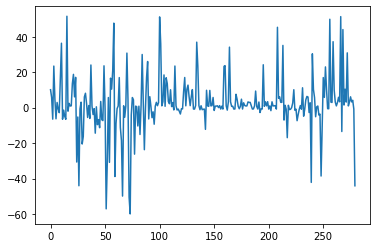

In [27]:
plt.plot(episode_reward)

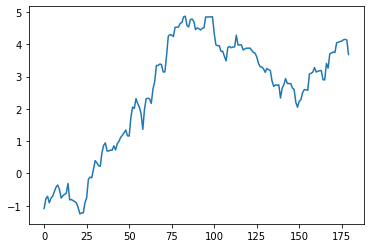

In [28]:
avg_reward = []
sum_reward = 0
span = 100
for i in range(len(episode_reward)):
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

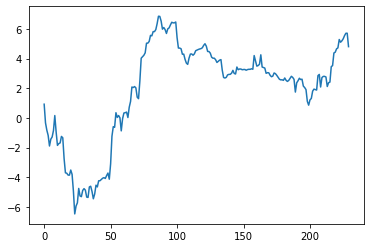

In [29]:
avg_reward = []
sum_reward = 0
span = 50
for i in range(len(episode_reward)):
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

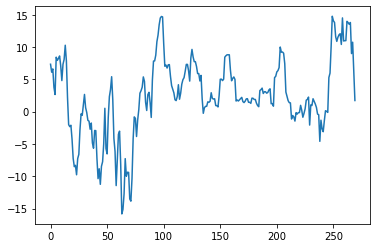

In [30]:
avg_reward = []
sum_reward = 0
span = 10
for i in range(len(episode_reward)):
    if i>=span: sum_reward -= episode_reward[i-span]
    sum_reward += episode_reward[i]
    if i>=span: avg_reward.append(sum_reward/span)
plt.plot(avg_reward)

In [ ]:
# agent.save_weights('ddpg_{}_weights.h5f'.format('32_3_rays_final'), overwrite=True)
# actor.save_weights('actor_32_3_rays_final.h5', overwrite=True) 
# critic.save_weights('critic_32_3_rays_final.h5', overwrite=True)

In [ ]:
env.make_obstacles()
env.reset()

In [31]:
#time.sleep(10.)
_ = agent.test(env, nb_episodes=50, visualize=True, nb_max_episode_steps=1000)

Testing for 50 episodes ...
2.500000000000001 0 58.471196437447716
Episode 1: reward: 20.611, steps: 448


KeyboardInterrupt: 

In [ ]:
# actor.save_weights('actor_32_3_rays_final.h5', overwrite=True) 
# critic.save_weights('critic_32_3_rays_final.h5', overwrite=True)

In [ ]:
actor.load_weights('actor_32_3_rays_final.h5')
critic.load_weights('critic_32_3_rays_final.h5')

In [ ]:
agent.load_weights('ddpg_{}_weights.h5f'.format('32_3_rays_final'))

In [ ]:
X = []
Y = []

In [ ]:
c = 1
observation = env.reset()
x = []
y = []
while c:
    keys = p.getKeyboardEvents()
    done = 0
    for k,v in keys.items():
        if (k == ord('i') and (v&p.KEY_IS_DOWN   )):
            action = [0]
            x.append(observation)
            y.append(0)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('j') and (v&p.KEY_IS_DOWN   )):
            val = 0.5 + random.random()/5 - 0.1
            action = [val]
            x.append(observation)
            y.append(val)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('l') and (v&p.KEY_IS_DOWN   )):
            val = -0.5 + random.random()/5 - 0.1
            action = [val]
            x.append(observation)
            y.append(val)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('u') and (v&p.KEY_IS_DOWN   )):
            val = 1 + random.random()/5 - 0.1
            action = [val]
            x.append(observation)
            y.append(val)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('o') and (v&p.KEY_IS_DOWN   )):
            val = -1 + random.random()/5 - 0.1
            action = [val]
            x.append(observation)
            y.append(val)
            observation, reward, done, info = env.step(action)
            env.render()
        elif (k == ord('r') and (v&p.KEY_IS_DOWN   )):
            c = 0
        if done:
            if env.completed==1:
                X.append(x)
                Y.append(y)
            x = []
            y = []
            observation = env.reset()
            #c = 0
    time.sleep(1/100)

In [ ]:
len(Y), len(Y[49])

In [ ]:
plt.plot([len(x) for x in X])

In [ ]:
for i in range(len(X)):
    print(i, len(X[i]), len(Y[i]))

In [ ]:
# import gym
# import numpy as np

# from stable_baselines.ddpg.policies import MlpPolicy
# from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
# from stable_baselines import DDPG

# # the noise objects for DDPG
# n_actions = env.action_space.shape[-1]
# param_noise = None
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

# model = DDPG(MlpPolicy, env, verbose=1, param_noise=param_noise, action_noise=action_noise)
# model.learn(total_timesteps=400000)

In [ ]:
X_train = []
y_train = []
for i in range(len(X)):
    for j in range(len(X[i])):
        X_train.append(X[i][j])
        y_train.append(Y[i][j])
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape, y_train.shape

In [ ]:
# np.save('X_train.npy', X_train)
# np.save('y_train.npy', y_train)

In [ ]:
X_train = np.expand_dims(X_train, axis=1)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
actor.fit(X_train, y_train, epochs = 50)